# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 2B: Advanced Concepts II - Solutions

In [1]:
# Add prior directory to system path
import sys
sys.path.append("../")

### Python Decorators

In [2]:
import types
import gt4py
import time

def get_repr(func) -> str:
    if isinstance(func, types.FunctionType):
        return func.__name__
    elif isinstance(func, gt4py.StencilObject):
        return func.definition_func.__name__ + "_" + func._gt_id_
    else:
        raise TypeError("Unrecognized type")
    
def print_all_times():
    for call in times:
        print(f"{call} called {ncalls[call]} times. Total time: {times[call]} secs")
        
times = {}
ncalls = {}

def timeit(func):
    def wrapper():
        start = time.perf_counter()
        func()
        stop = time.perf_counter()
        call = get_repr(func)
        times[call] = times.get(call, 0.0) + stop - start
        ncalls[call] = ncalls.get(call, 0) + 1
    return wrapper

@timeit
def say_whee():
    time.sleep(0.5)
    print("Whee!")

@timeit
def something_else():
    time.sleep(0.25)
    print("This is neat")


say_whee()
say_whee()

something_else()
something_else()

print_all_times()

Whee!
Whee!
This is neat
This is neat
say_whee called 2 times. Total time: 1.0059923809999987 secs
something_else called 2 times. Total time: 0.5093580919999994 secs


In [3]:
import numpy as np
import gt4py.storage as gt_storage
from gt4py import gtscript

backend = "debug"
dtype = np.float64

N = 10
shape = (N, N, N)

def make_zeros(backend, shape, dtype=np.float64, default_origin=(0, 0, 0)):
    """Return a zero'd gt4py storage for the given backend and shape"""
    return gt_storage.zeros(backend=backend, shape=shape, dtype=dtype, default_origin=default_origin)

times = {}
ncalls = {}

def timeit(func):
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        func(*args, **kwargs)
        stop = time.perf_counter()
        call = get_repr(func)
        times[call] = times.get(call, 0.0) + stop - start
        ncalls[call] = ncalls.get(call, 0) + 1
    return wrapper

def print_all_times():
    for call in times:
        print(f"{call} called {ncalls[call]} times. Total time: {times[call]} secs")


@timeit
@gtscript.stencil(backend=backend)
def do_something(field_in: gtscript.Field[dtype], field_out: gtscript.Field[dtype]):
    with computation(PARALLEL), interval(...):
        field_out = field_in + 1

u = make_zeros(backend, shape)
v = make_zeros(backend, shape)

do_something(u, v)

print_all_times()

do_something_2e5041ecfd called 1 times. Total time: 0.005260443999999254 secs


### 2. Transient diffusion

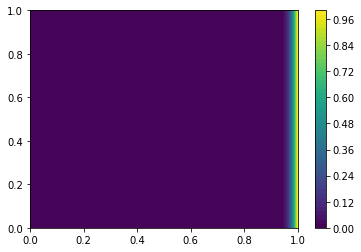

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import gt4py.storage as gt_storage
from gt4py import gtscript

from tools import print_generated_code

backend = "numpy"
dtype = np.float64

N = 128
shape = (N, N, 1)

DX = 1.0 / (N-1)
DT = DX * DX / (2 * 1) * 0.9 # Valid timestep for stability

def make_zeros(backend, shape, dtype=np.float64, default_origin=(0, 0, 0)):
    """Return a zero'd gt4py storage for the given backend and shape"""
    return gt_storage.zeros(backend=backend, shape=shape, dtype=dtype, default_origin=default_origin)

# Plotting
coord = np.linspace(0, 1, N)
X, Y = np.meshgrid(coord, coord)

def plot_solution(u):
    plt.contourf(X, Y, u.data[:, :, 0], 50)
    plt.colorbar()
    plt.show()
    
# GT4Py operator
@gtscript.function
def laplace(field):
    """Laplacian operator"""
    xd2 = -2 * field[0, 0, 0] + field[-1, 0, 0] + field[1, 0, 0]
    yd2 = -2 * field[0, 0, 0] + field[0, -1, 0] + field[0, 1, 0]
    return (xd2 + yd2) / (DX * DX)

@gtscript.stencil(backend=backend)
def take_timestep(u: gtscript.Field[dtype]):
    with computation(PARALLEL), interval(...):
        # Left
        with parallel(region[I[0]-1, :]):
            u[0, 0, 0] = u[1, 0, 0]
        
        # Right
        with parallel(region[I[-1] + 1, :]):
            u[0, 0, 0] = u[-1, 0, 0]
            
        # Bottom
        with parallel(region[:, J[0]-1]):
            u[0, 0, 0] = 0.
       
        # Top: not strictly necessary, since the stencil never iterates there
        with parallel(region[:, J[-1] + 1]):
            u[0, 0, 0] = 1.

        # Everywhere
        u += DT * laplace(u)


# Create storage (and set IC implicitly)
u = make_zeros(backend, shape)
for n in range(10):
    take_timestep(u, origin=(1, 1, 0))

plot_solution(u)

### 3. Distributed Computing

In [5]:
from gt4py import gtscript

rank = 0

south_edge = (0 <= rank <= 2)
west_edge = rank % 3 == 0
north_edge = (6 <= rank <= 8)
east_edge = (rank + 1) % 3 == 0

istart = gtscript.I[0] if west_edge else None
iend = gtscript.I[-1] if east_edge else None
jstart = gtscript.J[0] if south_edge else None
jend = gtscript.J[-1] if north_edge else None

@gtscript.function
def d2x(u):
    return (-2 * u[0, 0, 0] + u[-1, 0, 0] + u[1, 0, 0]) / (DX * DX)


@gtscript.function
def d2y(u):
    return (-2 * u[0, 0, 0] + u[0, -1, 0] + u[0, 1, 0]) / (DX * DX)

@gtscript.function
def lap_cube_cells(u):
    # Not necessary, but helps readability of the code
    from __externals__ import istart, iend, jstart, jend

    u_next = d2x(u) + d2y(u)

    # A practioner of numerical methods should rightly complain that these are committing finite difference crimes,
    # but correcting those would be overly verbose for an example.
    with parallel(region[istart, jstart - 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[-1, 1, 0]) / (DX * DX)
    with parallel(region[iend, jstart - 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[1, 1, 0]) / (DX * DX)
    with parallel(region[istart, jend + 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[-1, -1, 0]) / (DX * DX)
    with parallel(region[iend, jend + 1]):
        u_next = d2y(u) + (-2 * u[0, 0, 0] + u[1, 0, 0] + u[1, -1, 0]) / (DX * DX)

    with parallel(region[istart - 1, jstart]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[1, -1, 0]) / (DX * DX)
    with parallel(region[iend + 1, jstart]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[-1, -1, 0]) / (DX * DX)
    with parallel(region[istart - 1, jend]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[1, 1, 0]) / (DX * DX)
    with parallel(region[iend + 1, jend]):
        u_next = d2x(u) + (-2 * u[0, 0, 0] + u[0, 1, 0] + u[-1, 1, 0]) / (DX * DX)

    return u_next